# NHANES 2017–2018 (Kaggle) — Diabetes Risk Pipeline

This notebook is tailored for the **Kaggle** dataset *National Health and Nutrition Examination Survey 2017–2018* (RileyZurrin). It provides a reproducible pipeline from raw CSVs to a cleaned dataset and a modeling pipeline (Logistic Regression + XGBoost) with calibration, SHAP explainability, and subgroup fairness checks.

**Usage**:
- Place the Kaggle CSV files under the `data/` directory (keep any subfolders).
- Run the notebook cells sequentially. The notebook will help you find variable names and create a cleaned CSV for modeling.

**Outputs**:
- `data/nhanes_kaggle_2017_2018_cleaned.csv` — cleaned merged file ready for modeling.
- `models/` with trained models (if you run modeling cells).
- `figures/` with SHAP and calibration plots.

Note: this notebook does **not** download NHANES automatically — it expects the Kaggle CSVs to be downloaded by you and placed in `data/`.


## Requirements
Run:
```
pip install -r requirements.txt
```


In [1]:
# write requirements.txt
reqs = [
    "pandas>=1.3",
    "numpy>=1.21",
    "scikit-learn>=1.0",
    "xgboost>=1.6",
    "shap>=0.41",
    "matplotlib>=3.4",
    "seaborn>=0.11",
    "joblib>=1.1",
    "nbformat",
    "imblearn"
]
with open('requirements.txt','w') as f:
    f.write('\n'.join(reqs))
print('requirements.txt saved in working directory.')

requirements.txt saved in working directory.


## Load all Kaggle CSVs under data/
This cell finds and loads all CSV files recursively under `data/` into a dictionary `dfs` for inspection.

In [2]:
import glob, pandas as pd, os
csv_paths = glob.glob(os.path.join('data','**','*.csv'), recursive=True)
print(f'Found {len(csv_paths)} CSV files under data/ :')
for p in csv_paths[:200]:
    print(' -', p)

# Load CSVs into dfs dict
dfs = {}
for p in csv_paths:
    name = os.path.splitext(os.path.basename(p))[0]
    try:
        dfs[name] = pd.read_csv(p)
        print(f'Loaded {name}: rows={len(dfs[name])}, cols={len(dfs[name].columns)}')
    except Exception as e:
        print(f'Failed to read {p}: {e}')

Found 5 CSV files under data/ :
 - data\demographics.csv
 - data\dietary.csv
 - data\examination.csv
 - data\laboratory.csv
 - data\questionnaire.csv
Loaded demographics: rows=9254, cols=46
Loaded dietary: rows=9254, cols=362
Loaded examination: rows=8704, cols=490
Loaded laboratory: rows=8366, cols=386
Loaded questionnaire: rows=9254, cols=956


## Create mapping from actual column names to standard names
After running the search above, update `example_map` with the exact column names you found (left side). The right side are standardized names used later.

In [3]:
# Example mapping - update keys (left side) to match your dataset's actual column names found above.
# Right side stays as standardized column names used throughout the pipeline.
example_map = {
    'SEQN': 'SEQN',
    'RIDAGEYR': 'age',
    'RIAGENDR': 'gender',
    'RIDRETH1': 'race',
    'DIQ010': 'diag_self',
    'LBXGH': 'hbA1c',
    'LBXGLU': 'glu',
    'BMXBMI': 'bmi',

    'BPXSY1': 'bp_sys_1',
    'BPXSY2': 'bp_sys_2',
    'BPXSY3': 'bp_sys_3',

    'BPXDI1': 'bp_dia_1',
    'BPXDI2': 'bp_dia_2',
    'BPXDI3': 'bp_dia_3',

    'LBXTC': 'chol_total',
    'LBDHDD': 'chol_hdl',
    'SMQ020': 'smoke_now',

    'DIQ170': 'family_diabetes',
    'PAQ650': 'physically_active',

}

# Show which keys are present in loaded dfs
present = {}
for k in example_map.keys():
    found=False
    for df in dfs.values():
        if k in df.columns:
            found=True; break
    present[k]=found
print('Presence of example_map keys in loaded CSVs:')
for k,v in present.items():
    print(f' - {k}: {"FOUND" if v else "NOT FOUND"}')

print('\nIf some keys are NOT FOUND, re-run the search above and update example_map with the correct column names.')

Presence of example_map keys in loaded CSVs:
 - SEQN: FOUND
 - RIDAGEYR: FOUND
 - RIAGENDR: FOUND
 - RIDRETH1: FOUND
 - DIQ010: FOUND
 - LBXGH: FOUND
 - LBXGLU: FOUND
 - BMXBMI: FOUND
 - BPXSY1: FOUND
 - BPXSY2: FOUND
 - BPXSY3: FOUND
 - BPXDI1: FOUND
 - BPXDI2: FOUND
 - BPXDI3: FOUND
 - LBXTC: FOUND
 - LBDHDD: FOUND
 - SMQ020: FOUND
 - DIQ170: FOUND
 - PAQ650: FOUND

If some keys are NOT FOUND, re-run the search above and update example_map with the correct column names.


## Extract and merge selected variables from CSVs
This will create a merged DataFrame with SEQN and standardized column names.

In [4]:
from functools import reduce

def extract_and_merge(mapping, dfs):
    frames=[]
    seq_df=None
    # find a SEQN reference
    for dfname, df in dfs.items():
        if 'SEQN' in df.columns:
            seq_df = df[['SEQN']].copy()
            break
    if seq_df is None:
        raise RuntimeError('No SEQN found in any CSV. Ensure the Kaggle files include SEQN.')
    # For each mapping key, find which df contains it and extract
    for actual, std in mapping.items():
        if actual == 'SEQN':
            continue
        found=False
        for dfname, df in dfs.items():
            if actual in df.columns:
                sub = df[['SEQN', actual]].copy()
                sub = sub.rename(columns={actual: std})
                frames.append(sub)
                found=True
                break
        if not found:
            # create empty column placeholder
            frames.append(pd.DataFrame({'SEQN': seq_df['SEQN'], std: pd.NA}))
            print(f'Warning: {actual} not found; placeholder column created.')
    # merge all frames on SEQN
    merged = seq_df
    for f in frames:
        merged = merged.merge(f, on='SEQN', how='left')
    return merged

merged_df = extract_and_merge(example_map, dfs)

# -----------------------------
# Feature Engineering: Mean BP
# -----------------------------

sys_cols = [c for c in ['bp_sys_1','bp_sys_2','bp_sys_3'] if c in merged_df.columns]
dia_cols = [c for c in ['bp_dia_1','bp_dia_2','bp_dia_3'] if c in merged_df.columns]

if len(sys_cols) > 0:
    merged_df['bp_sys_mean'] = merged_df[sys_cols].mean(axis=1)

if len(dia_cols) > 0:
    merged_df['bp_dia_mean'] = merged_df[dia_cols].mean(axis=1)

#drop individual readings to avoid redundancy
merged_df = merged_df.drop(columns=sys_cols + dia_cols, errors='ignore')

print('Merged shape:', merged_df.shape)
display(merged_df.head())

Merged shape: (9254, 15)


,SEQN,age,gender,race,diag_self,hbA1c,glu,bmi,chol_total,chol_hdl,smoke_now,family_diabetes,physically_active,bp_sys_mean,bp_dia_mean
0,93703.0,2.0,2.0,5.0,2.0,NaN,NaN,17.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,2.0,1.0,3.0,2.0,NaN,NaN,15.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705.0,66.0,2.0,4.0,2.0,6.2,NaN,31.7,157.0,60.0,1.0,2.0,2.0,202.000000,62.000000
3,93706.0,18.0,1.0,5.0,2.0,5.2,NaN,21.5,148.0,47.0,2.0,2.0,2.0,111.333333,73.333333
4,93707.0,13.0,1.0,5.0,2.0,5.6,NaN,18.1,189.0,68.0,NaN,2.0,NaN,128.000000,47.333333


## Harmonize types, create derived features and diabetes label
Label rule: diag_self ==1 OR hbA1c >= 6.5 OR glu >= 126. Adults only (age >=18).

In [5]:
import numpy as np, os
df = merged_df.copy()

# Convert numeric-ish
num_cols = ['hbA1c','glu','bmi','chol_total','chol_hdl','age','smoke_now','family_diabetes','physically_active','bp_sys_mean','bp_dia_mean']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Gender/race as ints where applicable
if 'gender' in df.columns:
    df['gender'] = pd.to_numeric(df['gender'], errors='coerce').astype('Int64')


counts = {}
counts["Merged participants"] = len(df)
counts["Excluded age < 18"] = (df['age'] < 18).sum()

# Keep adults only
if 'age' in df.columns:
    df = df[df['age'] >= 18].copy()


# Label creation
df['diag_self'] = df.get('diag_self')
df['label'] = (
    ((df['diag_self'] == 1)) |
    ((df.get('hbA1c') >= 6.5)) |
    ((df.get('glu') >= 126))
).astype('Int64')



In [6]:
import pandas as pd

def cohort_characteristics(df, outcome_col='label'):
    rows = []

    groups = {
        "Overall": df,
        "No diabetes (label=0)": df[df[outcome_col] == 0],
        "Diabetes (label=1)": df[df[outcome_col] == 1],
    }

    for name, sub in groups.items():
        rows.append({
            "Group": name,
            "N": len(sub),
            "Age, mean ± SD": f"{sub['age'].mean():.1f} ± {sub['age'].std():.1f}",
            "Male, %": f"{100*(sub['gender'] == 1).mean():.1f}" if 'gender' in sub else "NA",
            "BMI, mean ± SD": f"{sub['bmi'].mean():.1f} ± {sub['bmi'].std():.1f}",
            "HbA1c, mean ± SD": f"{sub['hbA1c'].mean():.2f} ± {sub['hbA1c'].std():.2f}",
            "Glucose, mean ± SD": f"{sub['glu'].mean():.1f} ± {sub['glu'].std():.1f}",
            "Current smoker, %": f"{100*(sub['smoke_now'] == 1).mean():.1f}" if 'smoke_now' in sub else "NA",
        })

    return pd.DataFrame(rows)

table1 = cohort_characteristics(df)
display(table1)


,Group,N,"Age, mean ± SD","Male, %","BMI, mean ± SD","HbA1c, mean ± SD","Glucose, mean ± SD","Current smoker, %"
0,Overall,5856,49.9 ± 18.8,48.5,29.7 ± 7.4,5.84 ± 1.09,113.7 ± 37.3,40.3
1,No diabetes (label=0),4715,46.9 ± 18.7,47.6,29.0 ± 7.2,5.46 ± 0.38,101.0 ± 9.7,38.9
2,Diabetes (label=1),1141,62.4 ± 13.1,52.4,32.5 ± 7.8,7.30 ± 1.60,157.7 ± 58.2,46.2


In [7]:
counts["Final analytic cohort"] = len(df)

for k, v in counts.items():
    print(f"{k}: {v}")

out_csv = os.path.join('data','nhanes_kaggle_2017_2018_cleaned.csv')
df.to_csv(out_csv, index=False)
print('Cleaned merged CSV saved to', out_csv)
display(df.head())

Merged participants: 9254
Excluded age < 18: 3398
Final analytic cohort: 5856
Cleaned merged CSV saved to data\nhanes_kaggle_2017_2018_cleaned.csv


,SEQN,age,gender,race,diag_self,hbA1c,glu,bmi,chol_total,chol_hdl,smoke_now,family_diabetes,physically_active,bp_sys_mean,bp_dia_mean,label
2,93705.0,66.0,2,4.0,2.0,6.2,NaN,31.7,157.0,60.0,1.0,2.0,2.0,202.000000,62.000000,0
3,93706.0,18.0,1,5.0,2.0,5.2,NaN,21.5,148.0,47.0,2.0,2.0,2.0,111.333333,73.333333,0
5,93708.0,66.0,2,5.0,3.0,6.2,122.0,23.7,209.0,88.0,2.0,2.0,2.0,141.000000,77.000000,0
6,93709.0,75.0,2,4.0,2.0,6.3,NaN,38.9,176.0,65.0,1.0,2.0,2.0,118.666667,66.666667,0
8,93711.0,56.0,1,5.0,2.0,5.7,107.0,21.3,238.0,72.0,2.0,2.0,1.0,101.333333,66.666667,0


# EDA: Feature distributions and correlations


In [8]:

import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('figures', exist_ok=True)

eda_cols = [c for c in ['age','gender','race','bmi','diag_self','hbA1c','glu','chol_total','chol_hdl','smoke_now','family_diabetes','physically_active','bp_sys_mean','bp_dia_mean'] if c in df.columns]
model_features = [c for c in ['age','gender','race','bmi','chol_total','chol_hdl','smoke_now','family_diabetes','physically_active','bp_sys_mean','bp_dia_mean'] if c in df.columns]

print('EDA columns:', eda_cols)
print('Model features (LEAK-FREE):', model_features)

EDA columns: ['age', 'gender', 'race', 'bmi', 'diag_self', 'hbA1c', 'glu', 'chol_total', 'chol_hdl', 'smoke_now', 'family_diabetes', 'physically_active', 'bp_sys_mean', 'bp_dia_mean']
Model features (LEAK-FREE): ['age', 'gender', 'race', 'bmi', 'chol_total', 'chol_hdl', 'smoke_now', 'family_diabetes', 'physically_active', 'bp_sys_mean', 'bp_dia_mean']


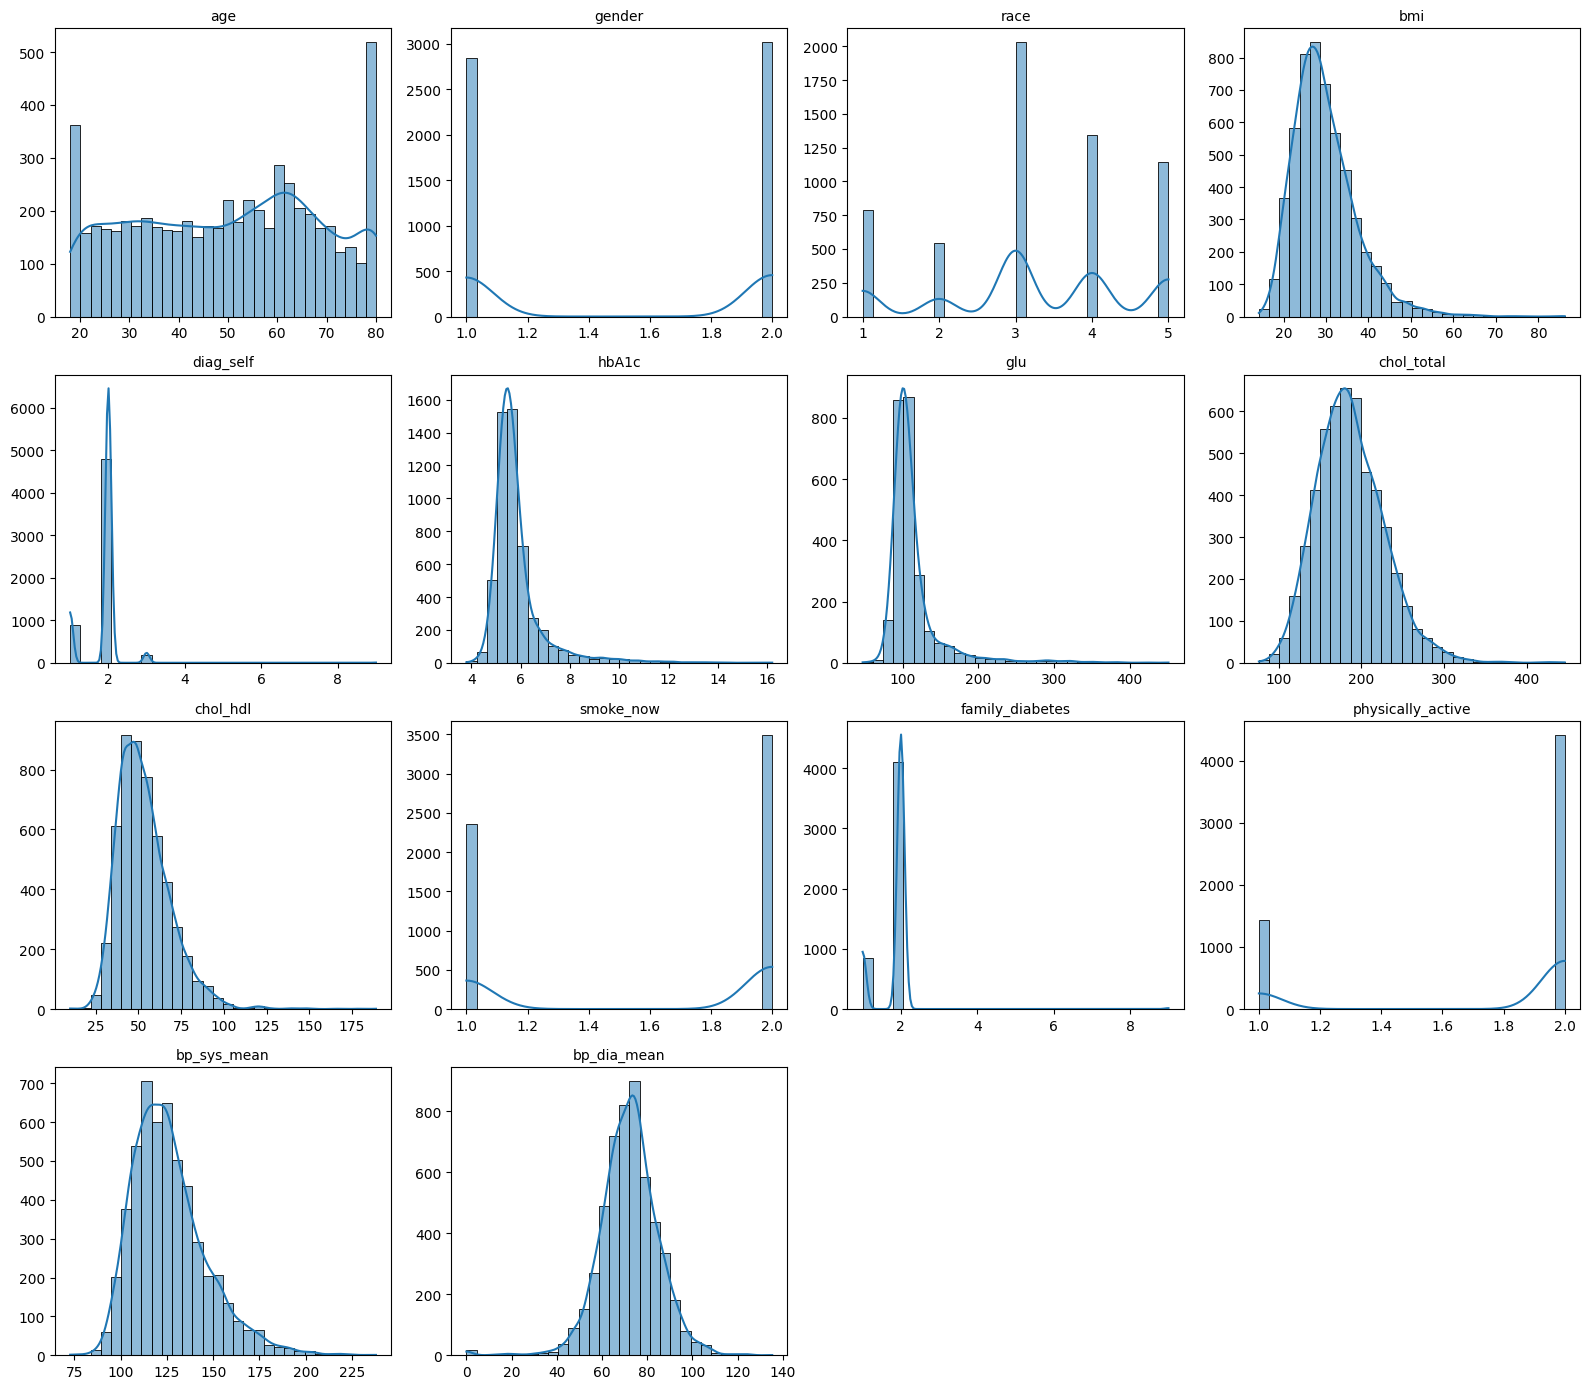

In [9]:
import math

n_cols = 4                              # number of plots per row
n_rows = math.ceil(len(eda_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, eda_cols):
    if col in df.columns:
        sns.histplot(df[col], bins=30, kde=True, ax=ax)
        ax.set_title(col, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('')

# Remove empty subplots
for i in range(len(eda_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('figures/eda_distributions_grid.png', dpi=300)
plt.show()

In [10]:
# =========================
# EDA: Outlier & Distribution Checks
# =========================

# -------------------------
# 1. Clinical / logical outlier checks (REAL outliers)
# -------------------------
clinical_bounds = {
    'age': (0, 120),
    'bmi': (10, 80),
    'glu': (40, 500),
    'chol_total': (50, 600),
    'chol_hdl': (5, 150),
    'bp_sys_mean': (60, 300),
    'bp_dia_mean': (30, 200),
    'hbA1c':(3,18)
}

print("=== Clinical Outlier Check ===")
for col, (low, high) in clinical_bounds.items():
    if col in df.columns:
        outliers = df[(df[col] < low) | (df[col] > high)]
        print(f"{col}: {len(outliers)} clinically implausible values")



=== Clinical Outlier Check ===
age: 0 clinically implausible values
bmi: 2 clinically implausible values
glu: 0 clinically implausible values
chol_total: 0 clinically implausible values
chol_hdl: 4 clinically implausible values
bp_sys_mean: 0 clinically implausible values
bp_dia_mean: 31 clinically implausible values
hbA1c: 0 clinically implausible values


In [11]:
# =========================
# Handle clinically implausible values
# =========================

import numpy as np

df.loc[(df['bmi'] < 10) | (df['bmi'] > 80), 'bmi'] = np.nan
df.loc[(df['chol_hdl'] < 5) | (df['chol_hdl'] > 150), 'chol_hdl'] = np.nan
df.loc[(df['bp_dia_mean'] < 30) | (df['bp_dia_mean'] > 200), 'bp_dia_mean'] = np.nan


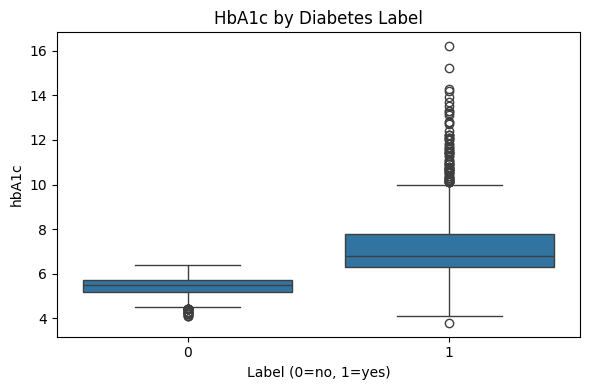

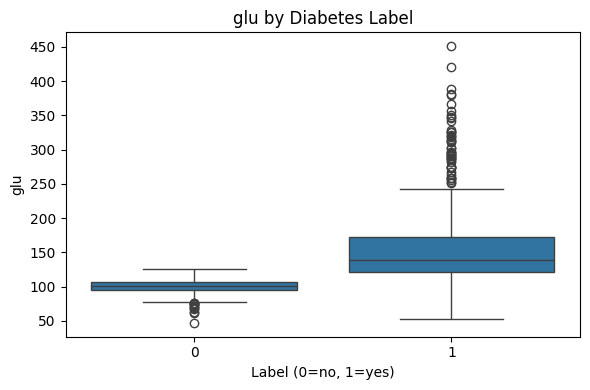

In [12]:
# CELL: EDA - numeric by label example (hbA1c)
import matplotlib.pyplot as plt, seaborn as sns
if 'hbA1c' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='label', y='hbA1c', data=df)
    plt.title('HbA1c by Diabetes Label')
    plt.xlabel('Label (0=no, 1=yes)')
    plt.tight_layout()
    plt.savefig('figures/eda_hba1c_by_label.png')
    plt.show()


if 'glu' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='label', y='glu', data=df)
    plt.title('glu by Diabetes Label')
    plt.xlabel('Label (0=no, 1=yes)')
    plt.tight_layout()
    plt.savefig('figures/eda_glu_by_label.png')
    plt.show()



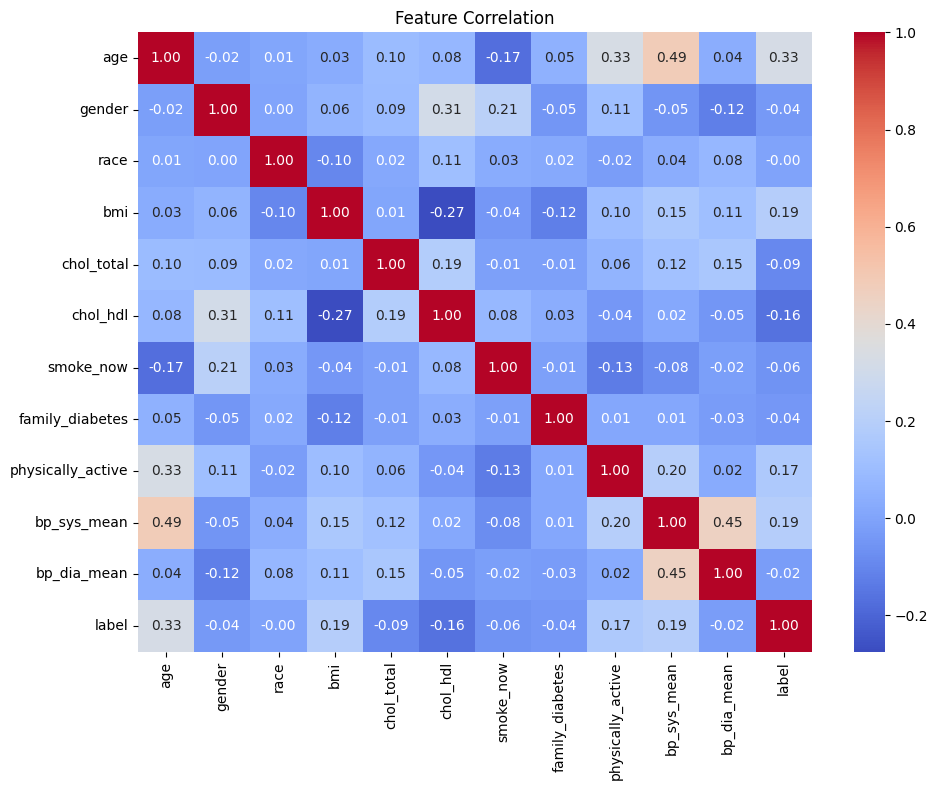

In [13]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[model_features + ['label']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation')
plt.tight_layout()
plt.savefig('figures/eda_correlation.png')
plt.show()



## Sanity checks 
Check label distribution, missingness.

In [14]:
import matplotlib.pyplot as plt, seaborn as sns
print('Rows, cols:', df.shape)
print('\nLabel distribution:')
display(df['label'].value_counts(dropna=False))


Rows, cols: (5856, 16)

Label distribution:


label
0    4715
1    1141
Name: count, dtype: Int64

,0,missing_pct
family_diabetes,878,14.99
chol_hdl,684,11.68
chol_total,680,11.61
bp_dia_mean,640,10.93
bp_sys_mean,609,10.40
bmi,424,7.24
age,0,0.00
race,0,0.00
gender,0,0.00
smoke_now,0,0.00


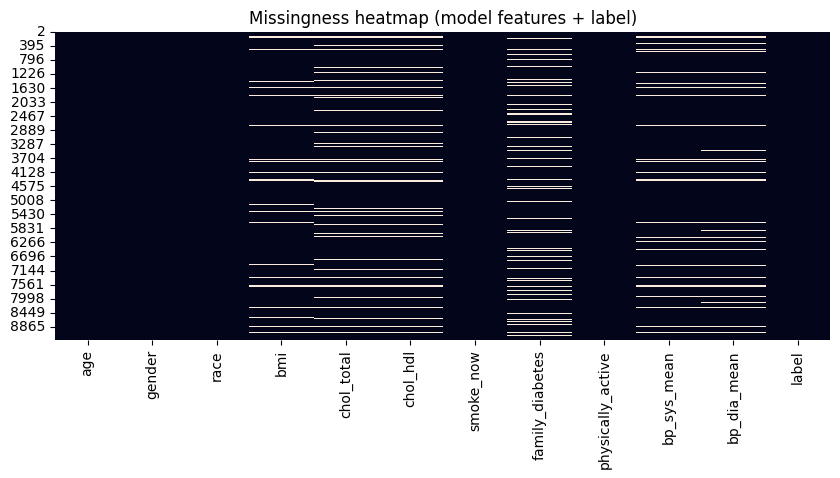

In [15]:
# CELL: missingness summary & heatmap for model features
import matplotlib.pyplot as plt, seaborn as sns
if 'df' in globals():
    miss = df[model_features].isnull().sum().sort_values(ascending=False)
    miss_pct = (miss / len(df) * 100).round(2)
    display(pd.concat([miss, miss_pct.rename('missing_pct')], axis=1).head(30))
    # heatmap for model features missingness
    plt.figure(figsize=(10,4))
    sns.heatmap(df[model_features + ['label']].isnull(), cbar=False)
    plt.title('Missingness heatmap (model features + label)')
    plt.show()
else:
    print('df not found')

## Modeling: preprocessing, training (Logistic + XGBoost), calibration
This cell runs a full pipeline: impute, optional scaling for logistic, train on train set, calibrate, evaluate on test set.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, brier_score_loss
import xgboost as xgb, joblib, os, pandas as pd, numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve



# Prepare X,y
df_model = df.dropna(subset=['label']).copy()
X = df_model[model_features].copy()
y = df_model['label'].astype(int).copy()

# Force numeric and turn non-numeric into NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Drop columns that become fully NaN
X = X.dropna(axis=1, how='all')
print("Final columns used:", X.columns.tolist())

# Simple imputation and train/test split
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, stratify=y, random_state=42)


Final columns used: ['age', 'gender', 'race', 'bmi', 'chol_total', 'chol_hdl', 'smoke_now', 'family_diabetes', 'physically_active', 'bp_sys_mean', 'bp_dia_mean']


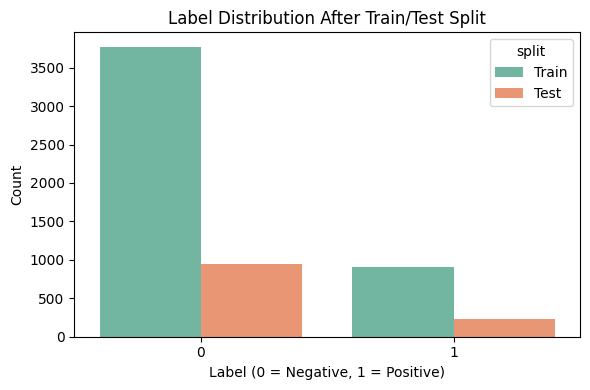

In [17]:
df_split = pd.DataFrame({
    'label': pd.concat([y_train, y_test]),
    'split': ['Train'] * len(y_train) + ['Test'] * len(y_test)
})

plt.figure(figsize=(6,4))
sns.countplot(data=df_split, x='label', hue='split', palette='Set2')
plt.title('Label Distribution After Train/Test Split')
plt.xlabel('Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('figures/Label Distribution After Train-Test Split.png')
plt.show()


In [18]:
from imblearn.over_sampling import SMOTE

# ===== APPLY SMOTE HERE =====
smote = SMOTE(
    sampling_strategy='auto',
    k_neighbors=5,
    random_state=42
)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_sm.value_counts())

Before SMOTE:
 label
0    3771
1     913
Name: count, dtype: int64
After SMOTE:
 label
0    3771
1    3771
Name: count, dtype: int64


In [19]:
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import numpy as np

def bootstrap_ci(y_true, y_pred, metric_fn, n_bootstrap=500, seed=42):
    rng = np.random.RandomState(seed)
    scores = []

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n = len(y_true)

    for _ in range(n_bootstrap):
        idx = rng.randint(0, n, n)  # resample with replacement
        if len(np.unique(y_true[idx])) < 2:
            continue  # skip degenerate samples
        scores.append(metric_fn(y_true[idx], y_pred[idx]))

    lower = np.percentile(scores, 2.5)
    upper = np.percentile(scores, 97.5)
    return np.mean(scores), lower, upper


In [20]:
# Logistic
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_train)
X_te_s = scaler.transform(X_test)

lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=2000, random_state=42)
lr.fit(X_tr_s, y_train)

# Calibrate logistic on a small validation split
X_lr_tr, X_lr_cal, y_lr_tr, y_lr_cal = train_test_split(X_tr_s, y_train, test_size=0.2, stratify=y_train, random_state=42)


calib = CalibratedClassifierCV(lr, method='isotonic', cv=5)
calib.fit(X_lr_cal, y_lr_cal)
y_pred_lr = calib.predict_proba(X_te_s)[:,1]

# Point estimates
auc_lr = roc_auc_score(y_test, y_pred_lr)
pr_auc_lr = average_precision_score(y_test, y_pred_lr)
brier_lr = brier_score_loss(y_test, y_pred_lr)

# Bootstrap CIs
auc_mean, auc_lo, auc_hi = bootstrap_ci(
    y_test, y_pred_lr, roc_auc_score
)

pr_mean, pr_lo, pr_hi = bootstrap_ci(
    y_test, y_pred_lr, average_precision_score
)

brier_mean, brier_lo, brier_hi = bootstrap_ci(
    y_test, y_pred_lr, brier_score_loss
)

print(
    f"Logistic (calibrated)\n"
    f"ROC-AUC = {auc_lr:.3f} (95% CI: {auc_lo:.3f}–{auc_hi:.3f})\n"
    f"PR-AUC  = {pr_auc_lr:.3f} (95% CI: {pr_lo:.3f}–{pr_hi:.3f})\n"
    f"Brier  = {brier_lr:.3f} (95% CI: {brier_lo:.3f}–{brier_hi:.3f})"
)


Logistic (calibrated)
ROC-AUC = 0.785 (95% CI: 0.754–0.812)
PR-AUC  = 0.408 (95% CI: 0.349–0.480)
Brier  = 0.135 (95% CI: 0.122–0.148)


In [21]:
# XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {'objective':'binary:logistic','eval_metric':'auc','seed':42}
bst = xgb.train(params, dtrain, num_boost_round=200, evals=[(dtrain,'train')], early_stopping_rounds=20, verbose_eval=False)
y_pred_xgb = bst.predict(dtest)

# Point estimates
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
pr_auc_xgb = average_precision_score(y_test, y_pred_xgb)
brier_xgb = brier_score_loss(y_test, y_pred_xgb)

# Bootstrap CIs
auc_mean, auc_lo, auc_hi = bootstrap_ci(
    y_test, y_pred_xgb, roc_auc_score
)

pr_mean, pr_lo, pr_hi = bootstrap_ci(
    y_test, y_pred_xgb, average_precision_score
)

brier_mean, brier_lo, brier_hi = bootstrap_ci(
    y_test, y_pred_xgb, brier_score_loss
)

print(
    f"XGBoost\n"
    f"ROC-AUC = {auc_xgb:.3f} (95% CI: {auc_lo:.3f}–{auc_hi:.3f})\n"
    f"PR-AUC  = {pr_auc_xgb:.3f} (95% CI: {pr_lo:.3f}–{pr_hi:.3f})\n"
    f"Brier  = {brier_xgb:.3f} (95% CI: {brier_lo:.3f}–{brier_hi:.3f})"
)

XGBoost
ROC-AUC = 0.790 (95% CI: 0.763–0.820)
PR-AUC  = 0.449 (95% CI: 0.394–0.518)
Brier  = 0.145 (95% CI: 0.129–0.162)


In [22]:
# Save models and imputer/scaler
os.makedirs('models', exist_ok=True)
joblib.dump({'imputer':imp,'scaler':scaler,'lr_cal':calib}, 'models/prep_and_lr_cal.joblib')
bst.save_model('models/xgb_model.json')
print('Models saved to models/')

Models saved to models/


# Model evaluation: confusion matrix and classification report


Confusion Matrix for LR:


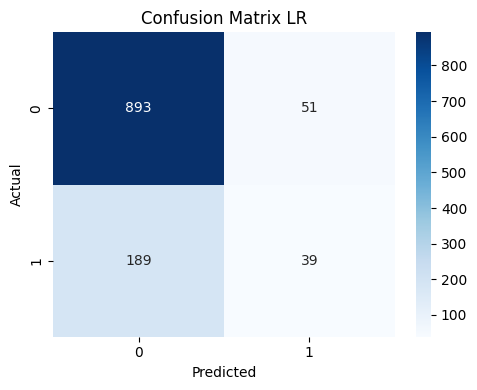


Classification Report:
              precision    recall  f1-score   support

           0     0.8253    0.9460    0.8815       944
           1     0.4333    0.1711    0.2453       228

    accuracy                         0.7952      1172
   macro avg     0.6293    0.5585    0.5634      1172
weighted avg     0.7491    0.7952    0.7578      1172



In [23]:
from sklearn.metrics import confusion_matrix,classification_report

# Convert predicted probabilities to class labels
y_pred_labels = (y_pred_lr >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix for LR:")

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix LR')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_LR.png')
plt.show()
plt.close()

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, digits=4))


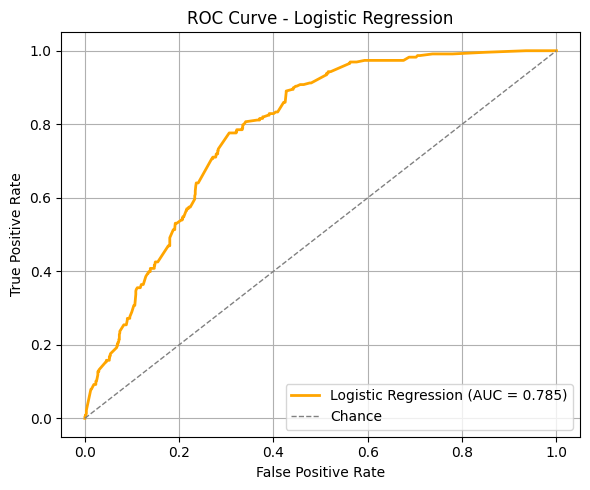

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/roc_lr.png')
plt.show()
plt.close()


Confusion Matrix for xgb:


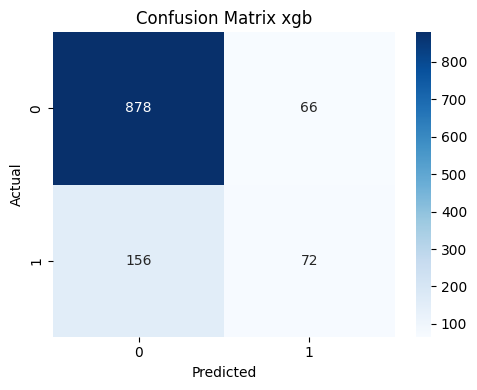


Classification Report:
              precision    recall  f1-score   support

           0     0.8491    0.9301    0.8878       944
           1     0.5217    0.3158    0.3934       228

    accuracy                         0.8106      1172
   macro avg     0.6854    0.6229    0.6406      1172
weighted avg     0.7854    0.8106    0.7916      1172



In [25]:
from sklearn.metrics import confusion_matrix,classification_report

# Convert predicted probabilities to class labels
y_pred_labels_xgb = (y_pred_xgb >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels_xgb)
print("Confusion Matrix for xgb:")

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix xgb')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_xgb.png')
plt.show()
plt.close()

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels_xgb, digits=4))


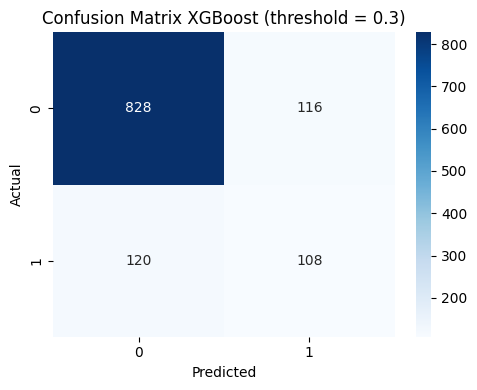


XGBoost @ threshold 0.3
              precision    recall  f1-score   support

           0     0.8734    0.8771    0.8753       944
           1     0.4821    0.4737    0.4779       228

    accuracy                         0.7986      1172
   macro avg     0.6778    0.6754    0.6766      1172
weighted avg     0.7973    0.7986    0.7980      1172



In [26]:
from sklearn.metrics import confusion_matrix, classification_report

t=0.3
y_pred_labels_xgb = (y_pred_xgb >= t).astype(int)

cm = confusion_matrix(y_test, y_pred_labels_xgb)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix XGBoost (threshold = {t})')
plt.tight_layout()
plt.savefig(f'figures/confusion_matrix_xgb_t{int(t*100)}.png')
plt.show()
plt.close()

print(f"\nXGBoost @ threshold {t}")
print(classification_report(y_test, y_pred_labels_xgb, digits=4))


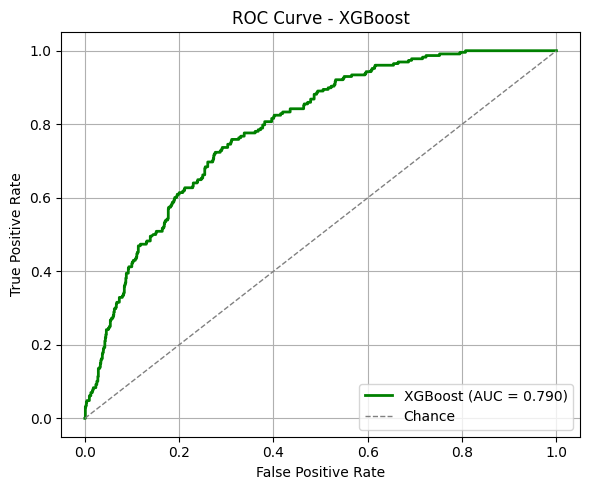

In [27]:
from sklearn.metrics import roc_curve

fpr_xgb, tpr_xgb, thresholds_roc_xgb = roc_curve(y_test, y_pred_xgb)

plt.figure(figsize=(6,5))
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/roc_xgb.png')
plt.show()
plt.close()


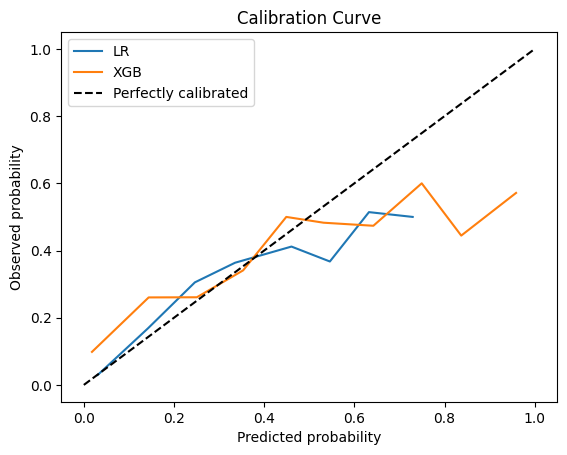

In [28]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Logistic Regression
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_pred_lr, n_bins=10)
plt.plot(prob_pred_lr, prob_true_lr, label='LR')

# XGBoost
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_pred_xgb, n_bins=10)
plt.plot(prob_pred_xgb, prob_true_xgb, label='XGB')

# Diagonal line
plt.plot([0,1],[0,1],'k--',label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.title('Calibration Curve')
plt.legend()
plt.savefig('figures/Calibration_Curve.png')
plt.show()


## SHAP explainability for XGBoost
Produces global summary and a per-patient example force plot (matplotlib).

Top features correlated with label (absolute): ['age', 'bmi', 'bp_sys_mean', 'physically_active', 'chol_hdl', 'chol_total', 'smoke_now', 'family_diabetes', 'gender', 'bp_dia_mean']


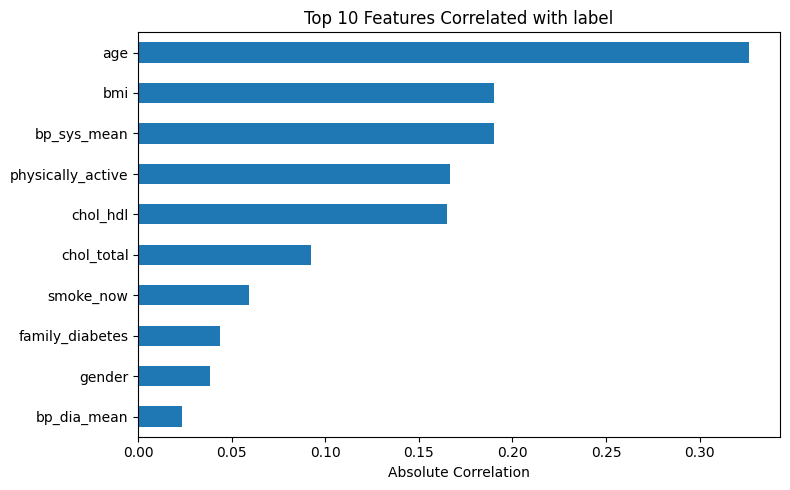

In [29]:
# Correlation with label: show top correlated features
corr = df[model_features + ['label']].corr()
corr_label = corr['label'].abs().sort_values(ascending=False).drop('label')
top_feats = corr_label.head(10).index.tolist()
print("Top features correlated with label (absolute):", top_feats)

plt.figure(figsize=(8,5))
corr_label.head(10).sort_values().plot(kind='barh')
plt.title("Top 10 Features Correlated with label")
plt.xlabel("Absolute Correlation")
plt.tight_layout()
plt.savefig('figures/Top_10_Features Correlated_with_label.png')
plt.show()

Saved SHAP summary to figures/shap_summary.png
Saved SHAP per-patient example to figures/shap_force_example.png


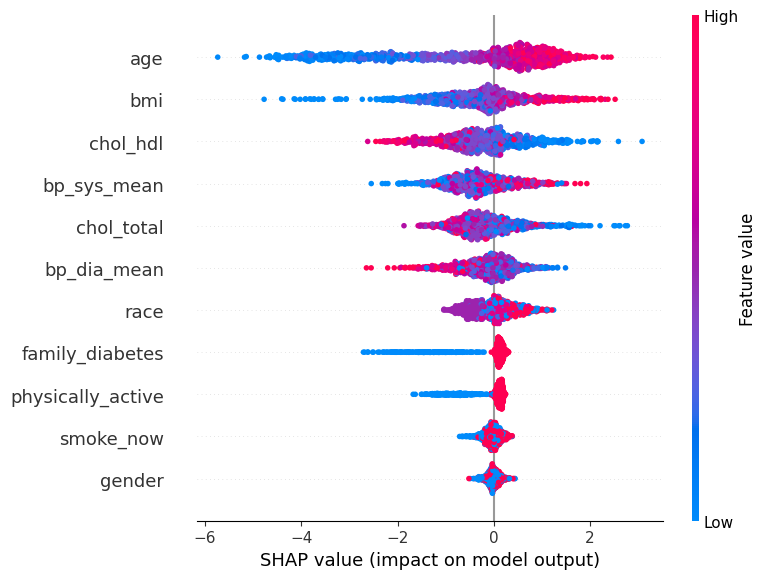

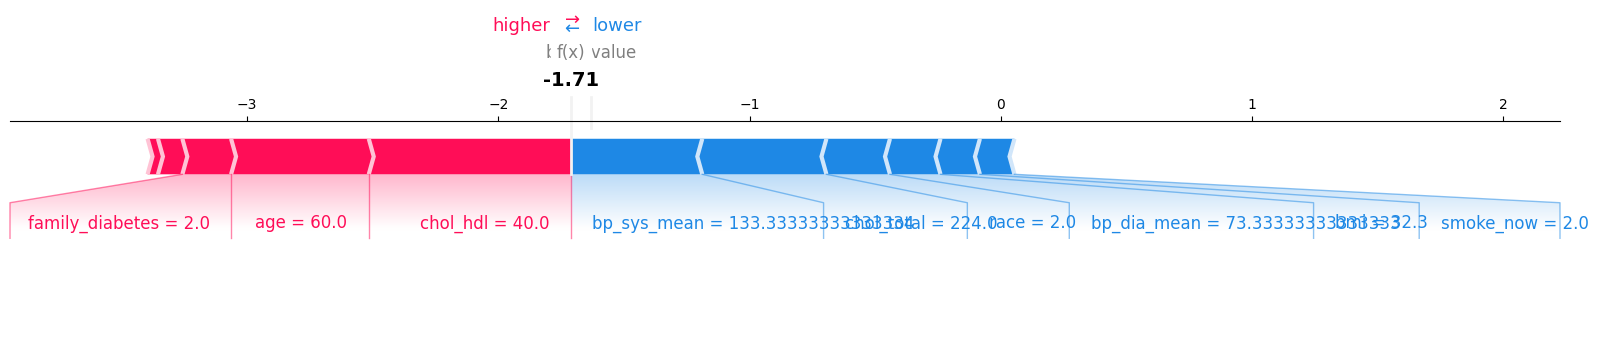

In [30]:
import shap, matplotlib.pyplot as plt, os
os.makedirs('figures', exist_ok=True)

# Prepare X_test as DataFrame (not scaled) for SHAP
X_test_df = X_test.copy()
explainer = shap.TreeExplainer(bst)
shap_vals = explainer.shap_values(X_test_df)

# Summary plot (global)
shap.summary_plot(shap_vals, X_test_df, show=False)
plt.savefig('figures/shap_summary.png')
print('Saved SHAP summary to figures/shap_summary.png')

# Per-patient example (first test row)
i = 0
if X_test_df.shape[0] > 0:
    shap.force_plot(explainer.expected_value, shap_vals[i,:], X_test_df.iloc[i,:], matplotlib=True, show=False)
    plt.savefig('figures/shap_force_example.png')
    print('Saved SHAP per-patient example to figures/shap_force_example.png')
else:
    print('No test rows for SHAP example.')

## Fairness / subgroup evaluation
Compute AUC by gender and age bins and plot calibration curve (global).

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

# Load saved components
saved = joblib.load('models/prep_and_lr_cal.joblib')

imputer = saved['imputer']
scaler = saved['scaler']
model = saved['lr_cal']     # calibrated logistic regression

feature_names = model_features

# Keep original X_test_df for fairness (age/gender/race stay available)
X_test_df = X_test_df.reset_index(drop=True)

# Model input only (correct feature order)
X_test_model = X_test_df[feature_names].copy().reset_index(drop=True)

# Apply preprocessing
X_test_imputed = imputer.transform(X_test_model)
X_test_scaled  = scaler.transform(X_test_imputed)

# Predict probabilities
y_pred_proba = pd.Series(model.predict_proba(X_test_scaled)[:, 1]).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)




C:\Users\kin_n77\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [32]:
import numpy as np
import pandas as pd

# REQUIREMENTS: you must already have these defined:
# X_test_df (with columns: age, gender, race), y_test (0/1), y_pred_proba (float probs)
X_test_df = X_test_df.copy()

# --- Age bins ---
X_test_df["age_group"] = pd.cut(
    X_test_df["age"],
    bins=[18, 40, 60, np.inf],
    labels=["18–39", "40–59", "60+"],
    right=False
)

# --- Gender mapping (adjust if your gender coding differs) ---
# Common NHANES: 1=Male, 2=Female
gender_map = {1: "Male", 2: "Female", "Male": "Male", "Female": "Female"}
X_test_df["gender_group"] = X_test_df["gender"].map(gender_map)

# --- Race mapping (NHANES RIDRETH1 style) ---
race_map = {1: "Hispanic", 2: "Hispanic", 3: "White", 4: "Black", 5: "Other"}
X_test_df["race_group"] = X_test_df["race"].map(race_map)

# Make sure indexes align
X_test_df = X_test_df.reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)
y_pred_proba = pd.Series(y_pred_proba).reset_index(drop=True)

X_test_df[["age_group","gender_group","race_group"]].head()


,age_group,gender_group,race_group
0,60+,Female,Hispanic
1,40–59,Female,Hispanic
2,40–59,Female,Other
3,60+,Female,White
4,40–59,Female,Hispanic


In [33]:
from sklearn.metrics import roc_auc_score

def print_auc_by_group(df, y_true, y_prob, group_col, min_n=50):
    print(f"\nAUC by {group_col}:")
    for g in sorted(df[group_col].dropna().unique()):
        mask = (df[group_col] == g)
        if mask.sum() < min_n:
            continue
        # AUC requires both classes present
        if len(set(y_true[mask])) < 2:
            print(f"  {g}: skipped (only one class in subgroup, n={mask.sum()})")
            continue
        auc = roc_auc_score(y_true[mask], y_prob[mask])
        print(f"  {g} → AUC = {auc:.4f} (n={mask.sum()})")

print_auc_by_group(X_test_df, y_test, y_pred_proba, "age_group")
print_auc_by_group(X_test_df, y_test, y_pred_proba, "gender_group")
print_auc_by_group(X_test_df, y_test, y_pred_proba, "race_group")



AUC by age_group:
  18–39 → AUC = 0.8488 (n=382)
  40–59 → AUC = 0.6968 (n=355)
  60+ → AUC = 0.6185 (n=435)

AUC by gender_group:
  Female → AUC = 0.8017 (n=595)
  Male → AUC = 0.7677 (n=577)

AUC by race_group:
  Black → AUC = 0.7944 (n=260)
  Hispanic → AUC = 0.8098 (n=283)
  Other → AUC = 0.8200 (n=221)
  White → AUC = 0.7915 (n=408)


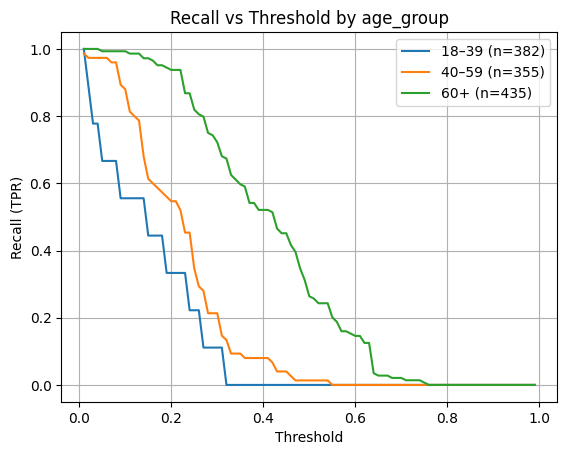

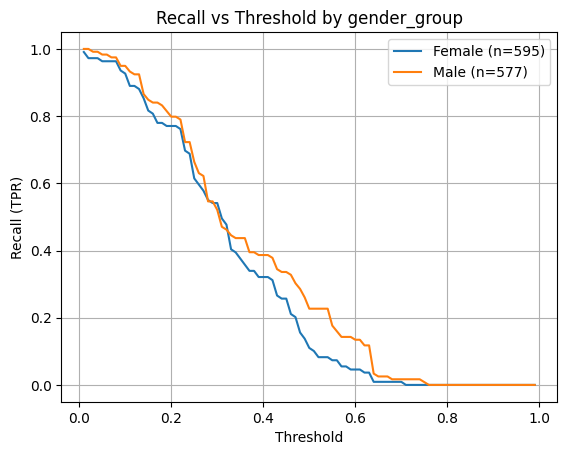

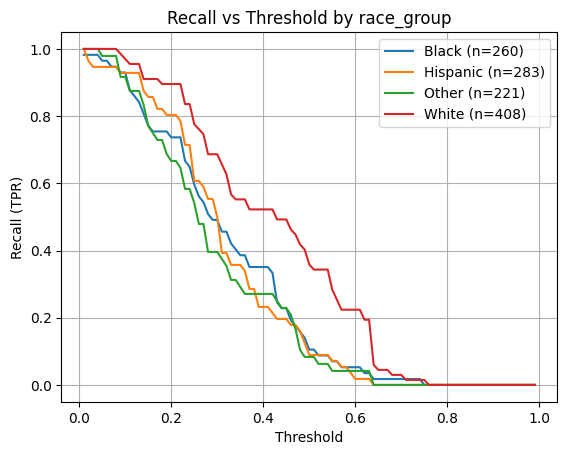

,group_col,group,n,threshold,precision,recall,FPR,FNR,TP,FP,TN,FN
0,age_group,18–39,382,0.2,0.600000,0.333333,0.005362,0.666667,3,2,371,6
1,age_group,18–39,382,0.3,1.000000,0.111111,0.000000,0.888889,1,0,373,8
2,age_group,18–39,382,0.5,NaN,0.000000,0.000000,1.000000,0,0,373,9
3,age_group,40–59,355,0.2,0.336066,0.546667,0.289286,0.453333,41,81,199,34
4,age_group,40–59,355,0.3,0.484848,0.213333,0.060714,0.786667,16,17,263,59
5,age_group,40–59,355,0.5,1.000000,0.013333,0.000000,0.986667,1,0,280,74
6,age_group,60+,435,0.2,0.369863,0.937500,0.790378,0.062500,135,230,61,9
7,age_group,60+,435,0.3,0.388060,0.722222,0.563574,0.277778,104,164,127,40
8,age_group,60+,435,0.5,0.426966,0.263889,0.175258,0.736111,38,51,240,106
9,gender_group,Female,595,0.2,0.388889,0.770642,0.271605,0.229358,84,132,354,25


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def metrics_at_threshold(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
    recall = tp / (tp + fn) if (tp + fn) else np.nan
    fpr    = fp / (fp + tn) if (fp + tn) else np.nan
    fnr    = fn / (fn + tp) if (fn + tp) else np.nan
    prec   = tp / (tp + fp) if (tp + fp) else np.nan
    return {"threshold": thr, "precision": prec, "recall": recall, "FPR": fpr, "FNR": fnr,
            "TP": tp, "FP": fp, "TN": tn, "FN": fn}

def subgroup_threshold_for_target_recall(y_true, y_prob, target_recall=0.80, grid=None):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    best = None
    for thr in grid:
        m = metrics_at_threshold(y_true, y_prob, thr)
        if np.isnan(m["recall"]):
            continue
        if m["recall"] >= target_recall:
            # among thresholds meeting recall target, prefer higher precision (or higher threshold)
            if (best is None) or (m["precision"] > best["precision"]) or (
                m["precision"] == best["precision"] and thr > best["threshold"]
            ):
                best = m
    return best

def plot_recall_vs_threshold_by_group(df, y_true, y_prob, group_col, min_n=50):
    thresholds = np.linspace(0.01, 0.99, 99)
    plt.figure()
    for g in sorted(df[group_col].dropna().unique()):
        mask = (df[group_col] == g)
        if mask.sum() < min_n:
            continue
        recalls = []
        for thr in thresholds:
            m = metrics_at_threshold(y_true[mask], y_prob[mask], thr)
            recalls.append(m["recall"])
        plt.plot(thresholds, recalls, label=f"{g} (n={mask.sum()})")
    plt.xlabel("Threshold")
    plt.ylabel("Recall (TPR)")
    plt.title(f"Recall vs Threshold by {group_col}")
    plt.legend()
    plt.grid(True)
    plt.show()

def subgroup_metrics_table(df, y_true, y_prob, group_col, thresholds=(0.5, 0.3, 0.2), min_n=50):
    rows = []
    for g in sorted(df[group_col].dropna().unique()):
        mask = (df[group_col] == g)
        if mask.sum() < min_n:
            continue
        for thr in thresholds:
            m = metrics_at_threshold(y_true[mask], y_prob[mask], thr)
            rows.append({"group_col": group_col, "group": g, "n": mask.sum(), **m})
    return pd.DataFrame(rows)

# --- 2A) Curves ---
plot_recall_vs_threshold_by_group(X_test_df, y_test, y_pred_proba, "age_group")
plot_recall_vs_threshold_by_group(X_test_df, y_test, y_pred_proba, "gender_group")
plot_recall_vs_threshold_by_group(X_test_df, y_test, y_pred_proba, "race_group")

# --- 2B) Multi-threshold table (choose thresholds you discuss in the paper) ---
tbl = pd.concat([
    subgroup_metrics_table(X_test_df, y_test, y_pred_proba, "age_group", thresholds=(0.5,0.3,0.2)),
    subgroup_metrics_table(X_test_df, y_test, y_pred_proba, "gender_group", thresholds=(0.5,0.3,0.2)),
    subgroup_metrics_table(X_test_df, y_test, y_pred_proba, "race_group", thresholds=(0.5,0.3,0.2)),
], ignore_index=True)

tbl.sort_values(["group_col","group","threshold"]).reset_index(drop=True)


In [35]:
target = 0.80
grid = np.linspace(0.01, 0.99, 99)

rows = []
for group_col in ["age_group", "gender_group", "race_group"]:
    for g in sorted(X_test_df[group_col].dropna().unique()):
        mask = (X_test_df[group_col] == g)
        if mask.sum() < 50:
            continue
        best = subgroup_threshold_for_target_recall(y_test[mask], y_pred_proba[mask], target_recall=target, grid=grid)
        if best is None:
            rows.append({"group_col": group_col, "group": g, "n": mask.sum(),
                         "target_recall": target, "threshold": np.nan,
                         "precision": np.nan, "recall": np.nan, "FPR": np.nan, "FNR": np.nan})
        else:
            rows.append({"group_col": group_col, "group": g, "n": mask.sum(),
                         "target_recall": target, **best})

pd.DataFrame(rows).sort_values(["group_col","group"]).reset_index(drop=True)


,group_col,group,n,target_recall,threshold,precision,recall,FPR,FNR,TP,FP,TN,FN
0,age_group,18–39,382,0.8,0.02,0.055556,0.888889,0.364611,0.111111,8,136,237,1
1,age_group,40–59,355,0.8,0.12,0.287081,0.800000,0.532143,0.200000,60,149,131,15
2,age_group,60+,435,0.8,0.25,0.383117,0.819444,0.652921,0.180556,118,190,101,26
3,gender_group,Female,595,0.8,0.16,0.357724,0.807339,0.325103,0.192661,88,158,328,21
4,gender_group,Male,577,0.8,0.19,0.347670,0.815126,0.397380,0.184874,97,182,276,22
5,race_group,Black,260,0.8,0.13,0.387097,0.842105,0.374384,0.157895,48,76,127,9
6,race_group,Hispanic,283,0.8,0.18,0.407080,0.821429,0.295154,0.178571,46,67,160,10
7,race_group,Other,221,0.8,0.14,0.430108,0.833333,0.306358,0.166667,40,53,120,8
8,race_group,White,408,0.8,0.24,0.306011,0.835821,0.372434,0.164179,56,127,214,11


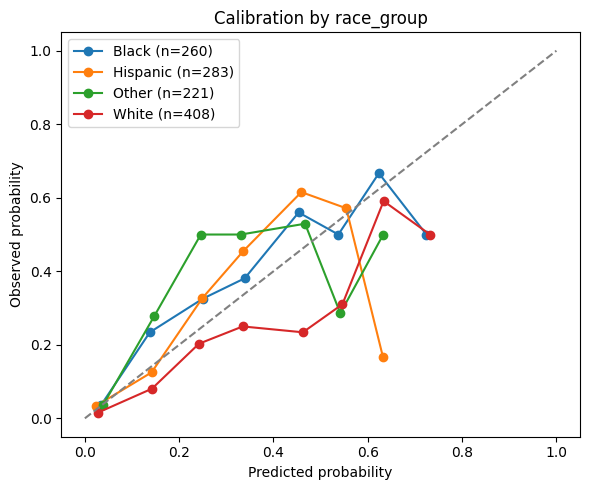

Saved: figures/calibration_by_race.png


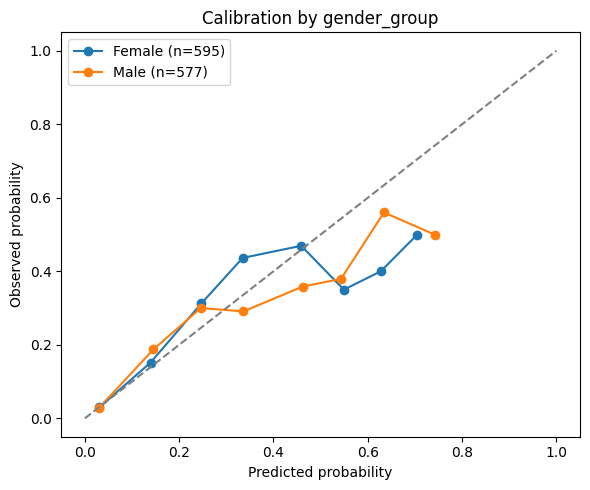

Saved: figures/calibration_by_gender.png


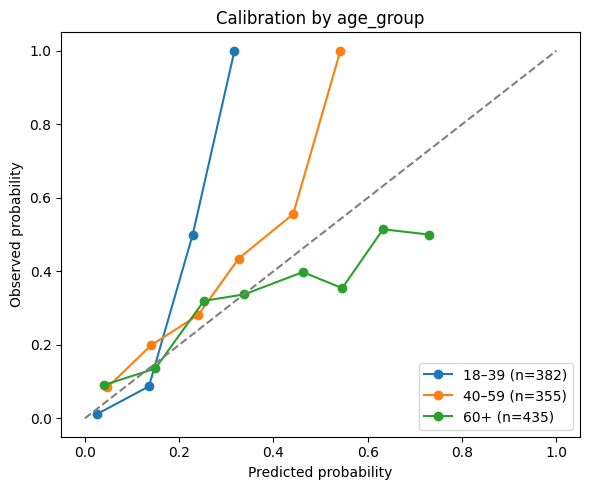

Saved: figures/calibration_by_age.png


In [36]:
import os
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)

def plot_calibration_by_group(df, y_true, y_prob, group_col, filename, min_n=50, n_bins=10):
    plt.figure(figsize=(6,5))
    for g in sorted(df[group_col].dropna().unique()):
        mask = (df[group_col] == g)
        if mask.sum() < min_n:
            continue
        prob_true, prob_pred = calibration_curve(y_true[mask], y_prob[mask], n_bins=n_bins)
        plt.plot(prob_pred, prob_true, marker='o', label=f"{g} (n={mask.sum()})")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('Predicted probability')
    plt.ylabel('Observed probability')
    plt.title(f'Calibration by {group_col}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Saved: {filename}")

plot_calibration_by_group(X_test_df, y_test, y_pred_proba, "race_group", "figures/calibration_by_race.png")
plot_calibration_by_group(X_test_df, y_test, y_pred_proba, "gender_group", "figures/calibration_by_gender.png")
plot_calibration_by_group(X_test_df, y_test, y_pred_proba, "age_group", "figures/calibration_by_age.png")


# Decision Curves

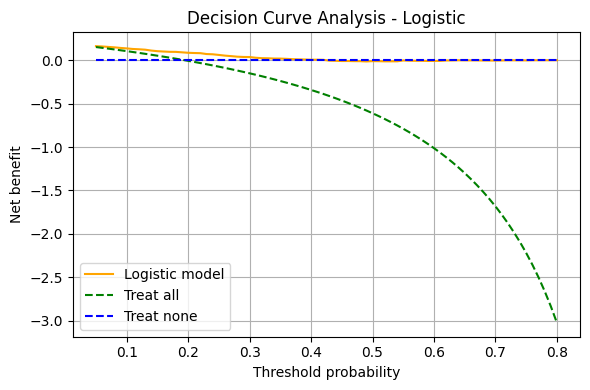

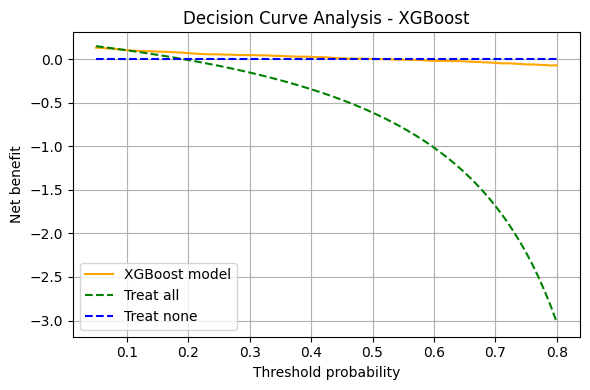

In [37]:
def decision_curve(y_true, y_pred_proba, thresholds=None):

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)
    
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    
    n = len(y_true)
    net_benefit = []

    for t in thresholds:
        # Predicted positives at this threshold
        preds = (y_pred_proba >= t).astype(int)
        tp = ((preds == 1) & (y_true == 1)).sum()
        fp = ((preds == 1) & (y_true == 0)).sum()
        # Net benefit formula
        nb = (tp / n) - (fp / n) * (t / (1 - t))
        net_benefit.append(nb)
    
    # Treat all: nb = prevalence - (1-prevalence)*(t/(1-t))
    prevalence = y_true.mean()
    nb_treat_all = prevalence - (1 - prevalence) * (thresholds / (1 - thresholds))
    nb_treat_none = np.zeros_like(thresholds)

    return thresholds, np.array(net_benefit), nb_treat_all, nb_treat_none


# Define clinically relevant threshold range
thresholds = np.linspace(0.05, 0.8, 76)

# ---------- Logistic Regression DCA ----------
th_lr, nb_lr, nb_all_lr, nb_none_lr = decision_curve(y_test, y_pred_lr, thresholds)

plt.figure(figsize=(6,4))
plt.plot(th_lr, nb_lr, label='Logistic model', color='orange')
plt.plot(th_lr, nb_all_lr, '--', label='Treat all', color='green')
plt.plot(th_lr, nb_none_lr, '--', label='Treat none', color='blue')
plt.xlabel('Threshold probability')
plt.ylabel('Net benefit')
plt.title('Decision Curve Analysis - Logistic')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/dca_lr.png')
plt.show()
plt.close()


# ---------- XGBoost DCA ----------
th_xgb, nb_xgb, nb_all_xgb, nb_none_xgb = decision_curve(y_test, y_pred_xgb, thresholds)

plt.figure(figsize=(6,4))
plt.plot(th_xgb, nb_xgb, label='XGBoost model', color='orange')
plt.plot(th_xgb, nb_all_xgb, '--', label='Treat all', color='green')
plt.plot(th_xgb, nb_none_xgb, '--', label='Treat none', color='blue')
plt.xlabel('Threshold probability')
plt.ylabel('Net benefit')
plt.title('Decision Curve Analysis - XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/dca_xgb.png')
plt.show()
plt.close()


# Hyperparameter tuning for Logistic Regression (simple GridSearch)


In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best ROC-AUC:", grid.best_score_)


# ---- tuned LR ----
best_model = grid.best_estimator_

X_lr_tr2, X_lr_cal2, y_lr_tr2, y_lr_cal2 = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

calib_lr = CalibratedClassifierCV(best_model, method="isotonic", cv=5)
calib_lr.fit(X_lr_cal2, y_lr_cal2)

# quick check
y_pred_proba_best = calib_lr.predict_proba(X_test)[:, 1]
print("Test ROC-AUC (calibrated tuned LR):", roc_auc_score(y_test, y_pred_proba_best))

# ---- SHAP background ("bg") for LR ----

shap_bg = X_lr_tr2.sample(n=min(200, len(X_lr_tr2)), random_state=42)


joblib.dump(
    {
        "imputer": imp,
        "scaler": scaler,              
        "lr_base": best_model,         
        "lr_cal": calib_lr,            
        "feature_names": list(X_train.columns),
        "shap_bg": shap_bg,            
    },
    "models/lr_tuned.joblib"
)

print("Saved: models/lr_tuned.joblib")



Best parameters: {'C': 1, 'solver': 'lbfgs'}
Best ROC-AUC: 0.8026618717980606
Test ROC-AUC (calibrated tuned LR): 0.7914273899791853
Saved: models/lr_tuned.joblib


In [39]:
# ----------------- Original LR (calibrated) -----------------

y_pred_orig = calib.predict_proba(X_te_s)[:, 1]
auc_orig = roc_auc_score(y_test, y_pred_orig)
pr_auc_orig = average_precision_score(y_test, y_pred_orig)
brier_orig = brier_score_loss(y_test, y_pred_orig)

print(f"Original LR - AUC: {auc_orig:.4f}, PR-AUC: {pr_auc_orig:.4f}, Brier: {brier_orig:.4f}")

# ----------------- Tuned LR (calibrated) -----------------

y_pred_tuned = calib_lr.predict_proba(X_te_s)[:, 1]
auc_tuned = roc_auc_score(y_test, y_pred_tuned)
pr_auc_tuned = average_precision_score(y_test, y_pred_tuned)
brier_tuned = brier_score_loss(y_test, y_pred_tuned)

print(f"Tuned LR - AUC: {auc_tuned:.4f}, PR-AUC: {pr_auc_tuned:.4f}, Brier: {brier_tuned:.4f}")

# -----------------  ΔAUC and paired bootstrap -----------------
delta_auc = auc_tuned - auc_orig
print(f"ΔAUC (Tuned - Original): {delta_auc:.4f}")


Original LR - AUC: 0.7850, PR-AUC: 0.4082, Brier: 0.1346
Tuned LR - AUC: 0.7912, PR-AUC: 0.4296, Brier: 0.1324
ΔAUC (Tuned - Original): 0.0062


## Save artifacts 
- Models are in `models/` and figures in `figures/`.
- Cleaned CSV is `data/nhanes_kaggle_2017_2018_cleaned.csv`.


In [40]:
import os
print('Models:', os.listdir('models') if os.path.exists('models') else 'models/ not found')
print('Figures:', os.listdir('figures') if os.path.exists('figures') else 'figures/ not found')
print('Cleaned CSV:', 'data/nhanes_kaggle_2017_2018_cleaned.csv' if os.path.exists('data/nhanes_kaggle_2017_2018_cleaned.csv') else 'not found')

Models: ['lr_tuned.joblib', 'prep_and_lr_cal.joblib', 'xgb_model.json']
Figures: ['calibration_by_age.png', 'calibration_by_gender.png', 'calibration_by_race.png', 'Calibration_Curve.png', 'confusion_matrix_LR.png', 'confusion_matrix_xgb.png', 'confusion_matrix_xgb_t30.png', 'dca_lr.png', 'dca_xgb.png', 'eda_correlation.png', 'eda_distributions_grid.png', 'eda_glu_by_label.png', 'eda_hba1c_by_label.png', 'Label Distribution After Train-Test Split.png', 'roc_lr.png', 'roc_xgb.png', 'shap_force_example.png', 'shap_summary.png', 'table1_cohort_characteristics.png', 'Top_10_Features Correlated_with_label.png']
Cleaned CSV: data/nhanes_kaggle_2017_2018_cleaned.csv


## References
- Kaggle dataset: RileyZurrin — National Health and Nutrition Examination Survey 2017–2018 (questionnaire & labs).
- CDC NHANES docs: https://www.cdc.gov/nchs/nhanes/index.htm
